In [33]:
import os
import time
import pandas as pd
import numpy as np

from PIL import Image

import cv2

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.cuda import device
from torch.optim.lr_scheduler import MultiStepLR
from torch.nn import functional as F

from torchvision import transforms
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torchvision.ops.misc import Permute
from torchvision.models import swin_transformer

import torchvision
from torchvision.transforms import v2
from torchvision import models

import matplotlib
from matplotlib import pyplot as plt

from typing import List, Optional, Callable

from tqdm.auto import tqdm

#!pip install -U segmentation-models-pytorch
from segmentation_models_pytorch import losses

#!pip install -U openmim
#!mim install mmcv
from mmcv.cnn import ConvModule

#!pip install pytorch_warmup
import pytorch_warmup as warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

#Dataset, dataloater and etc.

In [2]:
def create_folders_name(images_names: np.ndarray):
    folders_names = np.copy(images_names)
    for i in range(folders_names.shape[0]):
        image_name = folders_names[i]
        for j in range(len(image_name)):
            o = len(image_name) - j - 1
            if image_name[o] == '_':
                folders_names[i] = image_name[:o]
                break
    return folders_names

class SatteliteDataset(Dataset):
    def __init__(self, folders_names, images_names, transform, train=False, loader=default_loader):
        self.folders_names = folders_names
        self.images_names = images_names
        self.transform = transform
        self.loader = loader
        self.errors = 0
        self.train = train
        if self.train:
            self.train_transform = v2.Compose([
                v2.ColorJitter(brightness=[0.625, 1.6], contrast=[0.8, 1.25]),
                v2.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
                v2.RandomPosterize(bits=np.random.randint(3, 7), p=0.2),
                #v2.RandomSolarize(np.random.randint(1, 200), p=0.2),
                v2.RandomAutocontrast(0.2)
            ])

    def __len__(self):
        return self.images_names.shape[0]

    def __getitem__(self, idx):
        try:
            img = Image.open('OpenEarthMap_wo_xBD\\' + self.folders_names[idx] +'\\images\\' + self.images_names[idx])
        except:
            self.errors += 1
            print(self.errors, 'OpenEarthMap_wo_xBD\\' + self.folders_names[idx] +'\\images\\' + self.images_names[idx])
            return self.__getitem__(idx + 1)
        mask = Image.open('OpenEarthMap_wo_xBD\\' + self.folders_names[idx] +'\\labels\\' + self.images_names[idx])
        img, mask = self.transform(img, mask)
        if self.train:
            img = self.train_transform(img)
        img = v2.ToTensor()(img)
        img = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])(img)
        #mask = v2.Resize(size=(128, 128))(mask)
        mask = np.array(mask)
        mask = torch.tensor(mask, dtype=torch.long)
        return img, mask

class SatteliteTestDataset(Dataset):
    def __init__(self, folders_names, images_names, loader=default_loader):
        self.folders_names = folders_names
        self.images_names = images_names
        self.loader = loader
        self.errors = 0
    def __len__(self):
        return self.images_names.shape[0]

    def __getitem__(self, idx):
        try:
            img = Image.open('OpenEarthMap_wo_xBD\\' + self.folders_names[idx] +'\\images\\' + self.images_names[idx])
        except:
            self.errors += 1
            print(self.errors, 'OpenEarthMap_wo_xBD\\' + self.folders_names[idx] +'\\images\\' + self.images_names[idx])
            return self.__getitem__(idx + 1)
        img = v2.ToTensor()(img)
        img = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])(img)
        return img

In [4]:
train_images_names = np.loadtxt('OpenEarthMap_wo_xBD\\train.txt', dtype=str)
test_images_names = np.loadtxt('OpenEarthMap_wo_xBD\\test.txt', dtype=str)
val_images_names = np.loadtxt('OpenEarthMap_wo_xBD\\val.txt', dtype=str)

In [5]:
train_folders_names = create_folders_name(train_images_names)
test_folders_names = create_folders_name(test_images_names)
val_folders_names = create_folders_name(val_images_names)

Image Size (512, 512, 3)
Mask Size (512, 512)


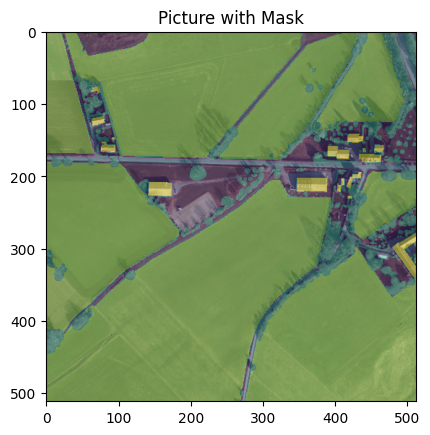

In [6]:
idx = 1
img = Image.open('OpenEarthMap_wo_xBD\\' + train_folders_names[idx] +'\\images\\' + train_images_names[idx])
mask = Image.open('OpenEarthMap_wo_xBD\\' + train_folders_names[idx] +'\\labels\\' + train_images_names[idx])
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.4)
plt.title('Picture with Mask')
plt.show()

In [7]:
train_transform = v2.Compose([
    v2.Resize(size=(512, 512)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    #v2.RandomAffine(degrees=(-30, 30), translate=(0.1, 0.1), scale=(0.8, 1.5), shear=(-4., 4.))
])

val_transform = v2.Compose([
    v2.Resize(size=(512, 512)),
])

train_dataset = SatteliteDataset(train_folders_names, train_images_names, train_transform, train=True)
val_dataset = SatteliteDataset(val_folders_names, val_images_names, val_transform)
test_dataset = SatteliteTestDataset(test_folders_names, test_images_names)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

#Model (Stepwise Feature Fusion + SwinV2_T)

In [10]:
class PatchExpansion(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim // 2)
        self.expand = nn.Linear(dim, 2 * dim, bias=False)

    def forward(self, x):
        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H, W, 2, 2, C // 4)
        x = x.permute(0, 1, 3, 2, 4, 5)
        x = x.reshape(B, H * 2, W * 2, C // 4)
        x = self.norm(x)
        return x

class Mlp(nn.Module):
    def __init__(self,
                 in_C,
                 out_C,
                 hidden_C=None,
                 act_layer=nn.GELU,
                 drop=0.05):
        super().__init__()
        if hidden_C == None:
            hidden_C = in_C
        self.lin1 = nn.Linear(in_C, hidden_C)
        self.act = act_layer()
        self.lin2 = nn.Linear(hidden_C, out_C)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.lin1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.drop(x)
        return x

# class SwinBlockV2(nn.Module):
#     def __init__(self, dim, num_heads, dr, adr, sdp):
#         super().__init__()
#         self.stb1 = swin_transformer.SwinTransformerBlockV2(dim, num_heads, [8, 8], [0, 0], dropout=dr,
#                                                             attention_dropout=adr, stochastic_depth_prob=sdp)
#         self.stb2 = swin_transformer.SwinTransformerBlockV2(dim, num_heads, [8, 8], [4, 4], dropout=dr,
#                                                             attention_dropout=adr, stochastic_depth_prob=sdp)

#     def forward(self, x):
#         x = self.stb1(x)
#         x = self.stb2(x)
#         return x

class ConvRelU(nn.Module):
    def __init__(self, inpup_C, output_C):
        super().__init__()
        self.conv1 = nn.Conv2d(inpup_C, output_C, kernel_size=(3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU() 
        self.conv2 = nn.Conv2d(output_C, output_C, kernel_size=(3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x

class EncoderSwinTransformer(swin_transformer.SwinTransformer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        weights = swin_transformer.Swin_V2_T_Weights.verify('IMAGENET1K_V1')
        self.load_state_dict(weights.get_state_dict(progress=True, check_hash=True))
        del self.norm
        del self.permute
        del self.avgpool
        del self.flatten
        del self.head
        # self.norm = norm_layer(num_features)
        # self.permute = Permute([0, 3, 1, 2])  # B H W C -> B C H W
        
        # self.swin_block1 = SwinBlockV2(C, 3, 0.005, 0.005, 0.02)
        # # self.swin_block12 = SwinBlockV2(C, 3, 0.005, 0.005, 0.005)
        # self.pm1 = swin_transformer.PatchMergingV2(C)

        # self.swin_block2 = SwinBlockV2(C * 2, 6, 0.01, 0.01, 0.08)
        # # self.swin_block22 = SwinBlockV2(C * 2, 6, 0.01, 0.01, 0.01)
        # self.pm2 = swin_transformer.PatchMergingV2(C * 2)

        # self.swin_block3 = SwinBlockV2(C * 4, 12, 0.01, 0.01, 0.12)
        # self.swin_block32 = SwinBlockV2(C * 4, 12, 0.01, 0.01, 0.12)
        # self.swin_block33 = SwinBlockV2(C * 4, 12, 0.01, 0.01, 0.12)
        # # self.swin_block34 = SwinBlockV2(C * 4, 12, 0.02, 0.02, 0.02)
        # # self.swin_block35 = SwinBlockV2(C * 4, 12, 0.02, 0.02, 0.02)
        # # self.swin_block36 = SwinBlockV2(C * 4, 12, 0.02, 0.02, 0.02)
        # self.pm3 = swin_transformer.PatchMergingV2(C * 4)

        # self.swin_block4 = SwinBlockV2(C * 8, 24, 0.01, 0.01, 0.16)
        # # self.swin_block42 = SwinBlockV2(C * 8, 24, 0.4, 0.4, 0.4)

    def forward(self, x):
        output = []
        for i in range(len(self.features)):
            x = self.features[i](x)
            if i % 2 == 1:
                output.append(x)
        return output
        
        # x1 = self.swin_block1(x)
        # # x1 = self.swin_block12(x)

        # x2 = self.pm1(x1)
        # x2 = self.swin_block2(x2)
        # # x2 = self.swin_block22(x2)

        # x3 = self.pm2(x2)
        # x3 = self.swin_block3(x3)
        # x3 = self.swin_block32(x3)
        # x3 = self.swin_block33(x3)
        # # x3 = self.swin_block34(x3)
        # # x3 = self.swin_block35(x3)
        # # x3 = self.swin_block36(x3)

        # x4 = self.pm3(x3)
        # x4 = self.swin_block4(x4)
        # # x4 = self.swin_block42(x4)
        return x1, x2, x3, x4

class Decoder(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.permute = Permute([0, 3, 1, 2])
        self.permute_back = Permute([0, 2, 3, 1])

        self.convReLU1 = ConvRelU(8 * C, C)
        self.up_sample1 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        
        self.convReLU2 = ConvRelU(4 * C, C)
        self.up_sample2 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        
        self.linear_fuse1 = Mlp(2 * C, C)

        self.convReLU3 = ConvRelU(2 * C, C)
        self.up_sample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.linear_fuse2 = Mlp(2 * C, C)

        self.convReLU4 = ConvRelU(C, C)
        self.linear_fuse3 = Mlp(2 * C, C)
        
        
        
        

        # self.mlp2 = nn.Linear(C * 4, C)
        # self.up_sample2 = nn.Upsample(scale_factor=4, mode='bicubic', align_corners=True)

        # self.mlp3 = nn.Linear(C * 2, C)
        # self.up_sample3 = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=True)

        
        # self.mlp4 = nn.Linear(4 * C, C)
        

        # self.permute = Permute([0, 3, 1, 2])
        # self.up1 = Up(C * 8 + C * 4, C * 4)
        # self.up2 = Up(C * 4 +  C * 2, C * 2)
        # self.up3 = Up(C * 2 + C, C)
        
        # self.up_sample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # self.double_conv1 = DoubleConv(C, C)
        # self.up_sample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # self.double_conv2 = DoubleConv(C, C)
    
        # self.mlp1 = nn.Linear(C * 8, C)
        # self.swin_block1 = SwinBlockV2(C, 4)
        # self.Permute1 = Permute([0, 3, 1, 2])
        # self.conv1 = nn.Conv2d(C * 8, C * 4, kernel_size=[5, 5], padding=[2, 2])
        # self.upsample1 = nn.Upsample(scale_factor=2, mode='bicubic')
        # self.conv_transpose1 = nn.ConvTranspose2d(C * 8, C, kernel_size=[4, 4], stride=[17, 17], 
        #                                           padding=[2, 2], output_padding=[1, 1])
        
        # # self.mlp2 = nn.Linear(C * 4, C)
        # # self.swin_block2 = SwinBlockV2(C, 4)
        # self.Permute2 = Permute([0, 3, 1, 2])
        # self.norm_layer2 = nn.LayerNorm(eps=1e-5, normalized_shape=32)
        # self.conv2 = nn.Conv2d(C * 4, C * 2, kernel_size=[5, 5], padding=[2, 2])
        # self.upsample2 = nn.Upsample(scale_factor=2, mode='bicubic')
        # self.conv_transpose2 = nn.ConvTranspose2d(C * 4, C, kernel_size=[4, 4], stride=[8],
        #                                           dilation=[3, 3], padding=[1, 1])

        # # self.mlp3 = nn.Linear(C * 2, C)
        # # self.swin_block3 = SwinBlockV2(C, 4)
        # self.Permute3 = Permute([0, 3, 1, 2])
        # self.norm_layer3 = nn.LayerNorm(eps=1e-5, normalized_shape=64)
        # self.conv3 = nn.Conv2d(C * 2, C, kernel_size=[5, 5], padding=[2, 2])
        # self.upsample3 = nn.Upsample(scale_factor=2, mode='bicubic')
        # self.conv_transpose3 = nn.ConvTranspose2d(C * 2, C, kernel_size=[4, 4], stride=[4])

        
        # # self.mlp4 = nn.Linear(C, C)
        # # self.swin_block4 = SwinBlockV2(C, 4)
        # self.Permute4 = Permute([0, 3, 1, 2])
        # self.norm_layer4 = nn.LayerNorm(eps=1e-5, normalized_shape=128)
        # self.conv4 = nn.Conv2d(C, C, kernel_size=[5, 5], padding=[2, 2])
        # self.upsample4 = nn.Upsample(scale_factor=4, mode='bicubic')
        # self.conv_transpose4 = nn.ConvTranspose2d(48, 48, kernel_size=[4, 4], stride=[2],
        #                                           padding=[1, 1])

        # # self.conv_transpose4 = nn.ConvTranspose(384, 48, scale_factor=2, mode='bilinear')
        
    def forward(self, encoder_x):
        x4, x3, x2, x1 = encoder_x
        x1 = self.permute(x1)
        x1 = self.convReLU1(x1)
        x1 = self.up_sample1(x1)

        x2 = self.permute(x2)
        x2 = self.convReLU2(x2)
        x2 = self.up_sample2(x2)
        
        x = torch.cat([x1, x2], dim=1)
        x = self.permute_back(x)
        x = self.linear_fuse1(x)

        x3 = self.permute(x3)
        x3 = self.convReLU3(x3)
        x3 = self.up_sample3(x3)
        
        x = self.permute(x)
        x = torch.cat([x, x3], dim=1)
        x = self.permute_back(x)
        x = self.linear_fuse2(x)

        x4 = self.permute(x4)
        x4 = self.convReLU4(x4)
        
        x = self.permute(x)
        x = torch.cat([x, x4], dim=1)
        x = self.permute_back(x)
        x = self.linear_fuse3(x)
        
        

        # self.conv11 = nn.Conv2d(C * 8, C, kernel_size=(1, 1), stride=(1, 1))
        # self.relu11 = nn.ReLU() 
        # self.conv12 = nn.Conv2d(C, C, kernel_size=(1, 1), stride=(1, 1))
        # self.relu12 = nn.ReLU()
        # self.up_sample1 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)

        # self.conv21 = nn.Conv2d(C * 4, C, kernel_size=(1, 1), stride=(1, 1))
        # self.relu21 = nn.ReLU() 
        # self.conv22 = nn.Conv2d(C, C, kernel_size=(1, 1), stride=(1, 1))
        # self.relu22 = nn.ReLU()
        # self.up_sample1 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

        # self.mlp12 = nn.Linear(2 * C, C)

        # self.conv31 = nn.Conv2d(C * 2, C, kernel_size=(1, 1), stride=(1, 1))
        # self.relu31 = nn.ReLU() 
        # self.conv32 = nn.Conv2d(C, C, kernel_size=(1, 1), stride=(1, 1))
        # self.relu32 = nn.ReLU()
        # self.up_sample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # self.mlp23 = nn.Linear(2 * C, C)

        # self.conv41 = nn.Conv2d(C, C, kernel_size=(1, 1), stride=(1, 1))
        # self.relu41 = nn.ReLU() 
        # self.conv42 = nn.Conv2d(C, C, kernel_size=(1, 1), stride=(1, 1))
        # self.relu42 = nn.ReLU()

        # self.mlp34 = nn.Linear(2 * C, C)

        
        # x4, x3, x2, x1 = encoder_x
        # x1 = self.mlp1(x1)
        # x1 = self.up_sample1(self.permute(x1))

        # x2 = self.mlp2(x2)
        # x4 = self.permute(x4)
        # x2 = self.up_sample2(self.permute(x2))

        # x3 = self.mlp3(x3)
        # x3 = self.up_sample3(self.permute(x3))

        # x = torch.cat([x1, x2, x3, x4], dim=1)
        
        # x = self.mlp4(self.permute_back(x))
        
        # x = self.up1(self.permute(encoder_x[3]), self.permute(encoder_x[2]))
        # x = self.up2(x, self.permute(encoder_x[1]))
        # x = self.up3(x, self.permute(encoder_x[0]))

        # x = self.up_sample1(x)
        # x = self.double_conv1(x)
        # x = self.up_sample2(x)
        # x = self.double_conv2(x)
        
        # x1 = self.mlp1(encoder_x[3])
        # x1 = self.swin_block1(x1)
        # x1 = self.Permute1(encoder_x[3])
        # x1 = self.conv1(x1)
        # x1 = self.upsample1(x1)

        # # x2 = self.mlp2(encoder_x[2])
        # # x2 = self.swin_block2(x2)
        # x2 = self.Permute2(encoder_x[2])
        # x2 = x1 + x2
        # x2 = self.norm_layer2(x2)
        # x2 = self.conv2(x2)
        # x2 = self.upsample2(x2)

        # # x3 = self.mlp3(encoder_x[1])
        # # x3 = self.swin_block3(x3)
        # x3 = self.Permute3(encoder_x[1])
        # x3 = x2 + x3
        # x3 = self.norm_layer3(x3)
        # x3 = self.conv3(x3)
        # x3 = self.upsample3(x3)

        # # x4 = self.mlp4(encoder_x[0])
        # # x4 = self.swin_block4(x4)
        # x4 = self.Permute4(encoder_x[0])
        # x4 = x3 + x4
        # x4 = self.norm_layer4(x4)
        # x4 = self.conv4(x4)
        # x4 = self.upsample4(x4)

        #x = torch.cat([x1, x2, x3, x4], dim=1)
        return x

class MyModel(nn.Module):
    def __init__(self, num_classes, C):
        super().__init__()
        # self.conv = nn.Conv2d(3, C, kernel_size=(4, 4), stride=(4, 4))
        # self.Permute1 = Permute([0, 2, 3, 1])
        # self.norm_layer = nn.LayerNorm(eps=1e-5, normalized_shape=C)

        self.encoder_swinv2_t = EncoderSwinTransformer(patch_size=[4, 4],
                                                       embed_dim=C,
                                                       depths=[2, 2, 6, 2],
                                                       num_heads=[3, 6, 12, 24],
                                                       window_size=[8, 8],
                                                       stochastic_depth_prob = 0.1,
                                                       block=swin_transformer.SwinTransformerBlockV2,
                                                       downsample_layer=swin_transformer.PatchMergingV2)
        self.decoder = Decoder(C)
        
        self.dropout = nn.Dropout(0.1)
        self.mlp = Mlp(C, num_classes)
        self.permute_back = Permute([0, 3, 1, 2])
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=4)

        # self.pmerge = swin_transformer.PatchMergingV2(384)
        # self.swin_block = SwinBlockV2(768, 48)
        # self.pexpand = PatchExpansion(768)
    
        
        # self.up_sample2 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        
        # self.Permute2 = Permute([0, 2, 3, 1])
        
        # self.drop = nn.Dropout(0.1)
        # self.conv2 = nn.Conv2d(C, num_classes, 1)

    def forward(self, x):
        # x = self.conv(x)
        # x = self.Permute1(x)
        # x = self.norm_layer(x)

        x_encoder = self.encoder_swinv2_t(x)
        x = self.decoder(x_encoder)

        x = self.dropout(x)
        masks_pred = self.mlp(x)
        masks_pred = self.permute_back(masks_pred)
        masks_pred = self.upsample(masks_pred)
        
        # masks_pred = self.up_sample2(masks_pred)
        
        # mask = F.softmax(masks_pred, dim=1)
        # mask = torch.argmax(mask, dim=1)
        return masks_pred

# class OLDDecoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.swin_block1 = SwinBlockV2(384, 24)

#         self.conv_transpose2 = nn.ConvTranspose2d(384, 192, kernel_size=(5, 5), stride=(2, 2))
#         self.swin_block2 = SwinBlockV2(192, 12)
        
#         self.conv_transpose3 = nn.ConvTranspose2d(192, 96, kernel_size=(5, 5), stride=(2, 2))
#         self.swin_block3 = SwinBlockV2(96, 6)
#         self.swin_block32 = SwinBlockV2(96, 6)
#         self.swin_block33 = SwinBlockV2(96, 6)

#         self.conv_transpose4 = nn.ConvTranspose2d(96, 48, kernel_size=(5, 5), stride=(2, 2))
#         self.swin_block4 = SwinBlockV2(48, 3)
        

#     def forward(self, x, encoder_x):

#         print(x.shape)
#         x = self.swin_block1(x)
#         print(x.shape)

#         x = self.conv_transpose2(x)
#         print(x.shape)
#         x = self.swin_block2(x)
#         x = self.swin_block32(x)
#         x = self.swin_block33(x)
        
#         x = self.conv_transpose3(x)
#         x = self.swin_block3(x)

#         x = self.conv_transpose4(x)
#         x = self.swin_block4(x)
#         return x

# class OLDMyModel(nn.Module):
#     def __init__(self, num_classes):
#         super().__init__()
#         self.conv = nn.Conv2d(3, 48, kernel_size=(4, 4), stride=(4, 4))
#         self.Permute1 = Permute([0, 2, 3, 1])
#         self.norm_layer = nn.LayerNorm(eps=1e-5, normalized_shape=48)

#         self.encoder = Encoder()

#         self.pmerge = swin_transformer.PatchMergingV2(384)
#         self.swin_block = SwinBlockV2(768, 48)
#         self.pexpand = PatchExpansion(768)

#         self.decoder = Decoder()
        
#         self.Permute2 = Permute([0, 3, 1, 2])
#         self.head = nn.Conv2d(12, num_classes, 1, padding='same')

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.Permute1(x)
#         x = self.norm_layer(x)

#         x_encoder = self.encoder(x)
        

#         x = self.pmerge(x_encoder[3])
#         x = self.swin_block(x)
#         x = self.pexpand(x)

#         x = self.decoder(x, x_encoder)

        

#         x = self.Permute2(x)
#         masks_pred = self.head(x)
#         mask = torch.argmax(masks_pred, dim=1)
#         return masks_pred, mask|

#Test Model Output

In [11]:
idx = 1
test_model = MyModel(9, 96)
img = Image.open('OpenEarthMap_wo_xBD\\' + train_folders_names[idx] +'\\images\\' + train_images_names[idx])
# img = v2.Resize((512, 512))(img)
img = v2.ToTensor()(img)
#print(img)
img = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])(img)
#print(img)
input_image = img.unsqueeze(0)
masks_pred = test_model(input_image)
print(masks_pred.shape)
print(masks_pred[:, 1:, :, :].shape)
print(test_model)

C:\Users\yav4ik\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


torch.Size([1, 9, 512, 512])
torch.Size([1, 8, 512, 512])
MyModel(
  (encoder_swinv2_t): EncoderSwinTransformer(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (0): SwinTransformerBlockV2(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttentionV2(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (cpb_mlp): Sequential(
              (0): Linear(in_features=2, out_features=512, bias=True)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=512, out_features=3, bias=False)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((96,), eps=1e-05, elementwi

#ModelSize

In [12]:
# test_model = MyModel(9, 96)
pytorch_total_params = sum(p.numel() for p in test_model.parameters())
print(pytorch_total_params)

29334675


#Metrics

In [83]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum() - (mask==0).sum()) / float(correct.numel() - (mask==0).sum())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=9):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(1, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#Train Loop

In [16]:
def fit(start_epoch, epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, warmup_scheduler, warmup_period):
    #torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    min_train_loss = np.inf
    decrease = 1 ; not_improve=0

    cros_entropy_criterion = nn.CrossEntropyLoss(ignore_index=0)
    model.to(device)
    fit_time = time.time()
    for e in range(start_epoch, epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        train_cros_entr = 0
        val_cros_entr = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask) * 2
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            with warmup_scheduler.dampening():
                if warmup_scheduler.last_step + 1 >= warmup_period:
                    scheduler.step()
            
            running_loss += loss.item()
            # train_cros_entr += cros_entropy_criterion(output, mask).item()
            #train_cros_entr += cros_entropy_criterion(output, mask).item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask) * 2                                 
                    test_loss += loss.item()
                    #val_cros_entr += cros_entropy_criterion(output, mask).item()
                    #val_cros_entr += cros_entropy_criterion(output, mask).item()
            
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))
            
            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    checkpoint = { 
                        'epoch': e,
                        'model': test_model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'sched': sched,
                        'warmup': warmup_scheduler}
                    vloss = "%.3f" % (test_loss/len(val_loader))
                    torch.save(checkpoint, f'fofl epoch={e} val_loss={vloss}.pt')
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                # if not_improve == 10:
                #     print('Loss not decrease for 10 times, Stop Training')
                #     break
            
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))

            print(train_cros_entr/len(train_loader), val_cros_entr/len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

#Load Model

In [ ]:
checkpoint = torch.load('model.pt')
test_model.load_state_dict(checkpoint['model'])
test_model.to(device)

#Save Model

In [22]:
checkpoint = { 
    'epoch': 1,
    'model': test_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'sched': sched,
    'warmup': warmup_scheduler}
#vloss = "%.3f" % (test_loss/len(val_loader))
torch.save(checkpoint, f'model epoch={1} val_loss={123}.pt')

In [84]:
epoch = 80
weight_decay = 1e-2
max_lr = 6e-4
warmup_period = 3000
start_epoch = 0

criterion = nn.CrossEntropyLoss(ignore_index=0)
# criterion = losses.LovaszLoss(mode= 'multiclass', ignore_index=0)
optimizer = torch.optim.AdamW(test_model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.PolynomialLR(optimizer, epoch * 1500)
warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)

history = fit(start_epoch, epoch, test_model, train_loader, val_loader, criterion, optimizer, sched, warmup_scheduler, warmup_period)

In [86]:
epoch = 40
weight_decay = 1e-2
max_lr = 4e-7
warmup_period = 3000

checkpoint = torch.load('fofl epoch=21 val_loss=0.537.pt', map_location=torch.device('cpu'))

start_epoch = checkpoint['epoch'] + 1
# start_epoch = 19
test_model = MyModel(9, 96)
test_model.load_state_dict(checkpoint['model'])
test_model.to(device)

optimizer = torch.optim.AdamW(test_model.parameters(), lr=max_lr, weight_decay=weight_decay)
optimizer.load_state_dict(checkpoint['optimizer'])

sched = checkpoint['sched']
warmup_scheduler = checkpoint['warmup']

print(start_epoch, epoch)
criterion = nn.CrossEntropyLoss(ignore_index=0)
history = fit(start_epoch, epoch, test_model, train_loader, val_loader, criterion, optimizer, sched, warmup_scheduler, warmup_period)

In [ ]:
0.526473659972725

In [87]:
test_model.eval()
time1 = time.time()
with torch.no_grad():
    for idx in range(len(test_images_names)):
        img = Image.open('OpenEarthMap_wo_xBD\\' + test_folders_names[idx] +'\\images\\' + test_images_names[idx])
        big_image = Image.open('1024\\' + test_folders_names[idx] +'\\images\\' + test_images_names[idx])
        size = big_image.size
        input_image = v2.ToTensor()(img)
        input_image = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])(input_image)
        input_image = val_transform(input_image)
        input_image = input_image.unsqueeze(0).to(device)
        test_model.upsample = nn.Upsample((size[1], size[0]), mode='bilinear')
        masks = test_model(input_image)
        masks = F.softmax(masks, dim=1)
        mask = torch.argmax(masks, dim=1)
        mask = mask.cpu().detach().numpy()
        mask = mask[0, :, :]
        mask = mask.astype(np.uint8)
        im = Image.fromarray(mask)
        im.save(f"test_prediction/{test_images_names[idx][:-4]}.png")
print(time.time() - time1)

In [29]:
for idx in range(1500):
    if test_images_names[idx] == 'tyrolw_9.tif':
        print(idx)
        break

1347


In [69]:
def mask_to_image(mask):
    color0 = np.array([0, 0, 0])
    color1 = np.array([128, 0, 0])
    color2 = np.array([0, 255, 36])
    color3 = np.array([148, 148, 148])
    color4 = np.array([255, 255, 255])
    color5 = np.array([34, 97, 98])
    color6 = np.array([0, 69, 255])
    color7 = np.array([75, 181, 73])
    color8 = np.array([226, 31, 7])
    colors = np.array([color0, color1, color2, color3, color4, color5, color6, color7, color8])
    img = np.zeros((np.array(mask).shape[0], np.array(mask).shape[1], 3), dtype=np.uint8)

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            img[i, j] = colors[mask[i, j]]
    image = Image.fromarray(img)
    return image
    

kyoto_47.tif


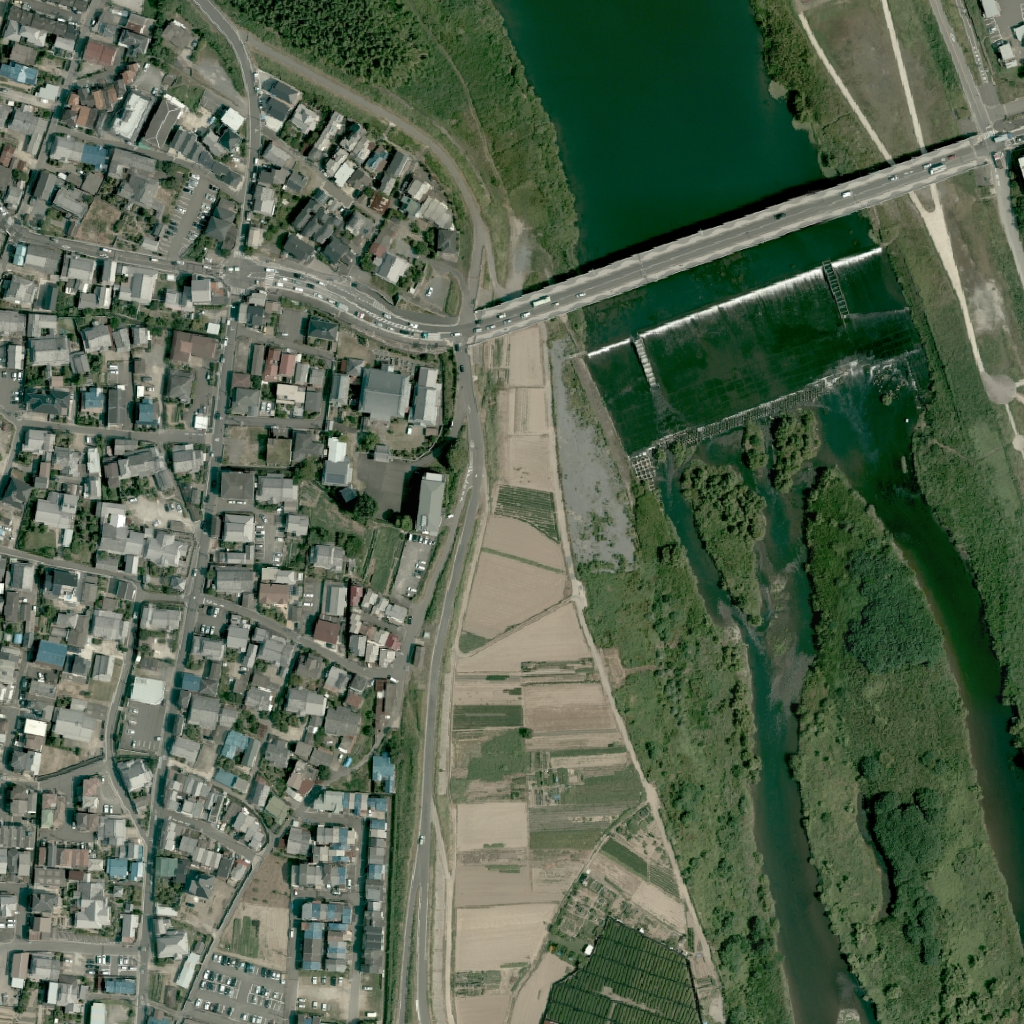

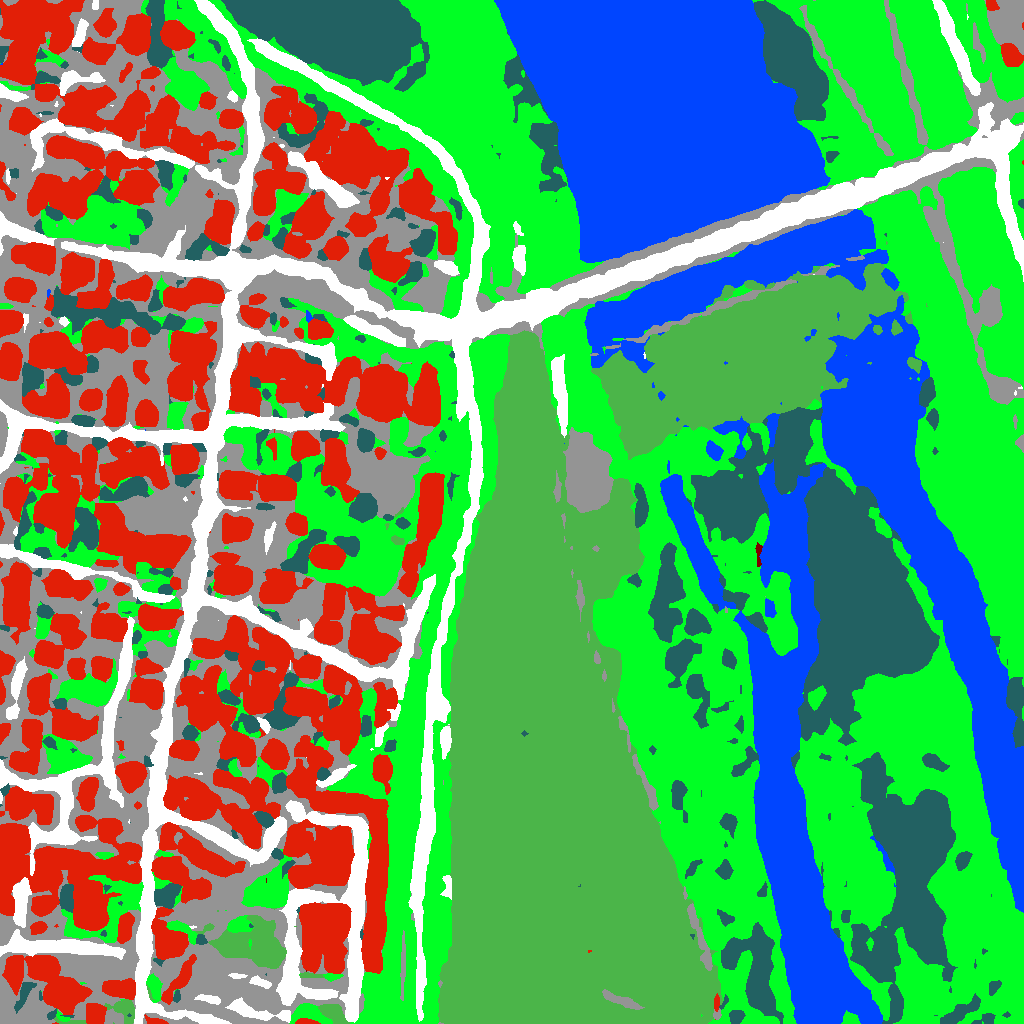

tyrolw_9.tif


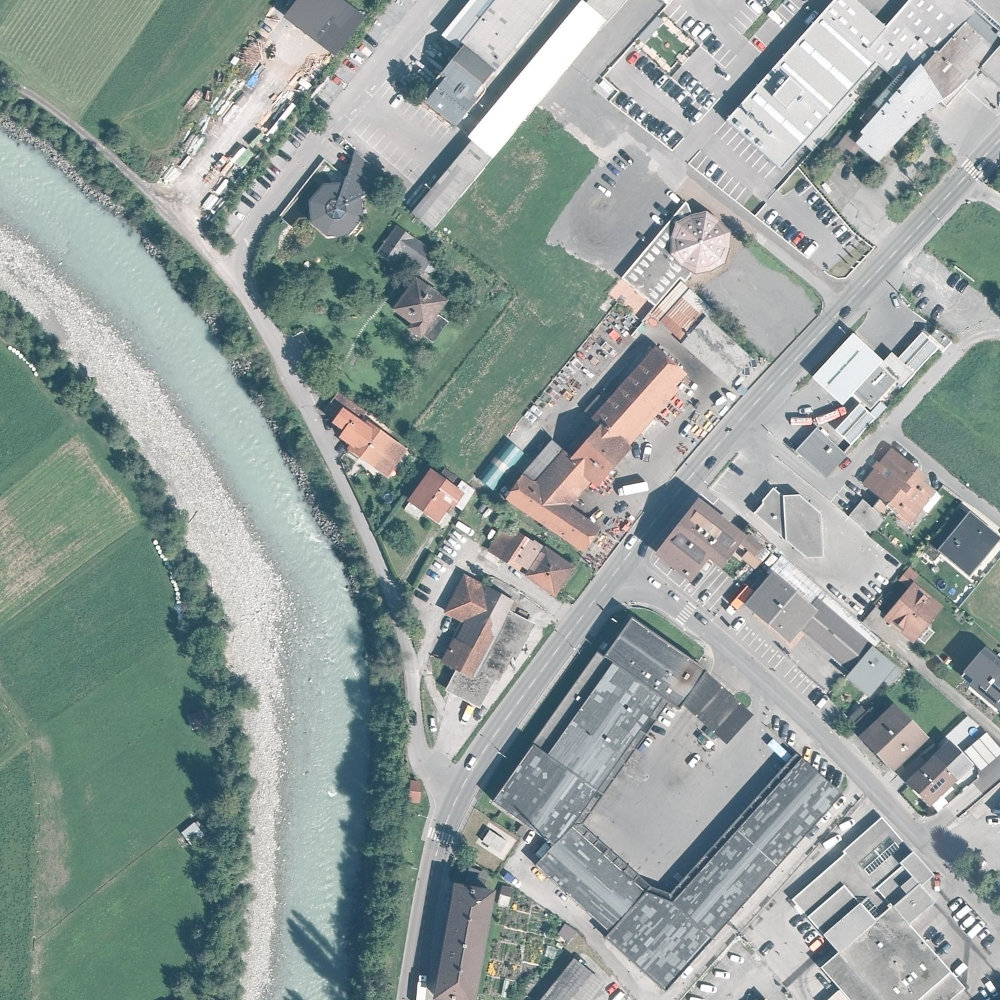

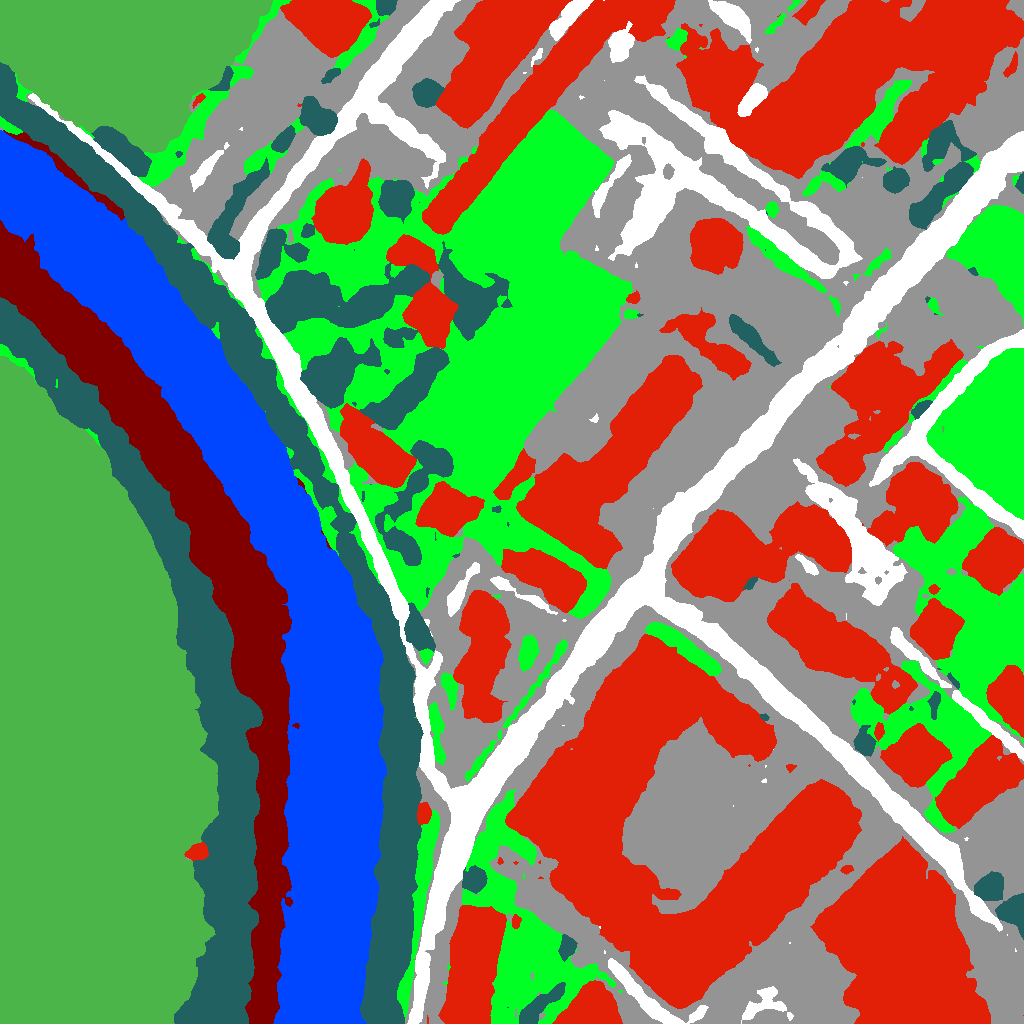

In [82]:
idx_list = [608, 1347]
test_model.upsample = nn.UpsamplingBilinear2d(scale_factor=8)
for idx in idx_list:
    img = Image.open('1024\\' + test_folders_names[idx] +'\\images\\' + test_images_names[idx])
    #mask = Image.open('OpenEarthMap_wo_xBD\\' + train_folders_names[idx] +'\\labels\\' + train_images_names[idx])
    #print('Image Size', np.asarray(img).shape)
    # img = v2.Resize(size=(512, 512))(img)
    input_image = v2.ToTensor()(img)
    input_image = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])(input_image)
    input_image = val_transform(input_image)
    #input_image = input_image.to(device).unsqueeze(0)\
    input_image = input_image.unsqueeze(0).to(device)
    masks = test_model(input_image)
    #masks = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)(masks)
    masks = F.softmax(masks, dim=1)
    masks = torch.argmax(masks, dim=1)
    mask = masks.cpu().detach().numpy()
    # mask = np.absolute(mask)
    imgm = mask_to_image(mask[0, :, :])
    print(test_images_names[idx])
    display(img)
    display(imgm)
    imgm.save(f'{idx}.png')
    #mask = np.rint()
    # plt.imshow(img)
    # plt.title('Picture')
    # plt.show()
    
    
    # plt.imshow(mask, cmap=cmap)
    # plt.title('Mask')
    # plt.show()

kyoto_47.tif


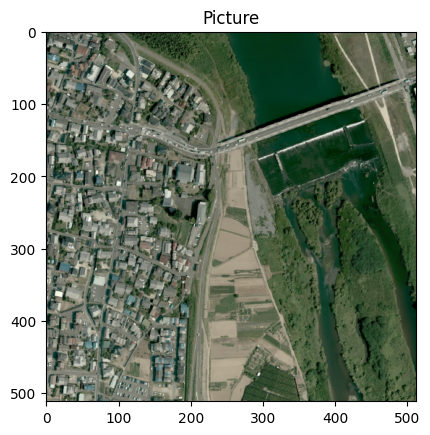

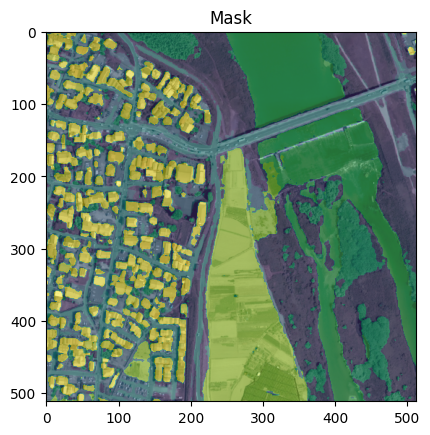

tyrolw_9.tif


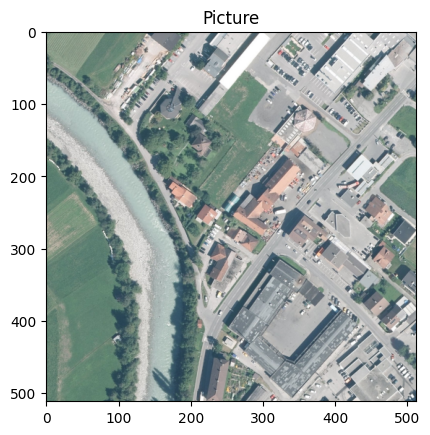

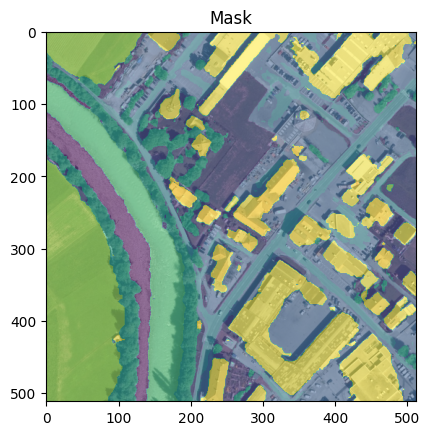

In [77]:
idx_list = [608, 1347]
for idx in idx_list:
        img = Image.open('OpenEarthMap_wo_xBD\\' + test_folders_names[idx] +'\\images\\' + test_images_names[idx])
    #real_mask = Image.open('OpenEarthMap_wo_xBD\\' + train_folders_names[idx] +'\\labels\\' + train_images_names[idx])
    #mask = Image.open('OpenEarthMap_wo_xBD\\' + train_folders_names[idx] +'\\labels\\' + train_images_names[idx])
    #print('Image Size', np.asarray(img).shape)
    # img = v2.Resize(size=(512, 512))(img)
    input_image = v2.ToTensor()(img)
    input_image = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])(input_image)
    input_image = val_transform(input_image)
    #input_image = input_image.to(device).unsqueeze(0)\
    input_image = input_image.unsqueeze(0).to(device)
    masks = test_model(input_image)
    #masks = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)(masks)
    masks = F.softmax(masks, dim=1)
    masks = torch.argmax(masks, dim=1)
    mask = masks.cpu().detach().numpy()
    # mask = np.absolute(mask)
    mask = mask[0, :, :]
    #mask = np.rint()
    print(test_images_names[idx])
    plt.imshow(img)
    plt.title('Picture')
    plt.show()
    
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)
    plt.title('Mask')
    plt.show()

tensor([[[8, 8, 8,  ..., 2, 2, 2],
         [8, 8, 8,  ..., 2, 2, 2],
         [8, 8, 8,  ..., 2, 2, 2],
         ...,
         [2, 3, 3,  ..., 8, 8, 8],
         [2, 2, 3,  ..., 8, 8, 8],
         [2, 2, 2,  ..., 8, 8, 8]]], device='cuda:0')
[[[8 8 8 ... 2 2 2]
  [8 8 8 ... 2 2 2]
  [8 8 8 ... 2 2 2]
  ...
  [2 3 3 ... 8 8 8]
  [2 2 3 ... 8 8 8]
  [2 2 2 ... 8 8 8]]]
(512, 512)
(512, 512)


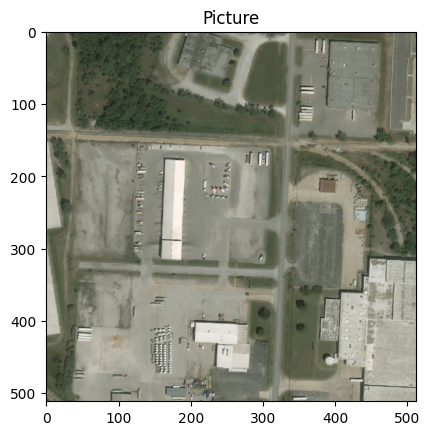

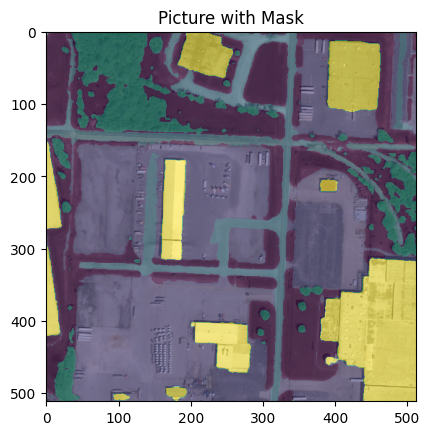

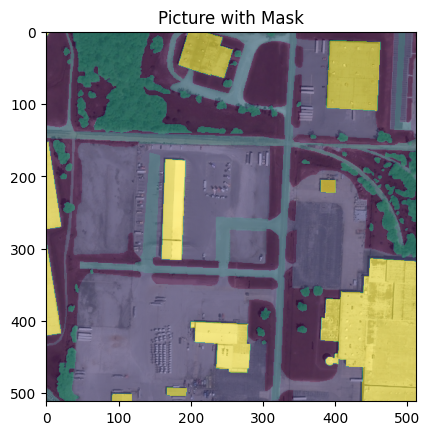

In [55]:
idx = 1000
img = Image.open('OpenEarthMap_wo_xBD\\' + train_folders_names[idx] +'\\images\\' + train_images_names[idx])
real_mask = Image.open('OpenEarthMap_wo_xBD\\' + train_folders_names[idx] +'\\labels\\' + train_images_names[idx])
#mask = Image.open('OpenEarthMap_wo_xBD\\' + train_folders_names[idx] +'\\labels\\' + train_images_names[idx])
#print('Image Size', np.asarray(img).shape)
# img = v2.Resize(size=(512, 512))(img)
input_image = v2.ToTensor()(img)
input_image = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])(input_image)
input_image = val_transform(input_image)
#input_image = input_image.to(device).unsqueeze(0)\
input_image = input_image.unsqueeze(0).to(device)
masks = test_model(input_image)
#masks = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)(masks)
masks = F.softmax(masks, dim=1)
masks = torch.argmax(masks, dim=1)
print(masks)
mask = masks.cpu().detach().numpy()
# mask = np.absolute(mask)
print(mask)
mask = mask[0, :, :]
#mask = np.rint()
print(mask.shape)
print(img.size)
plt.imshow(img)
plt.title('Picture')
plt.show()

plt.imshow(img)
plt.imshow(mask, alpha=0.5)
plt.title('Picture with Mask')
plt.show()

plt.imshow(img)
plt.imshow(real_mask, alpha=0.5)
plt.title('Picture with Mask')
plt.show()

In [27]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

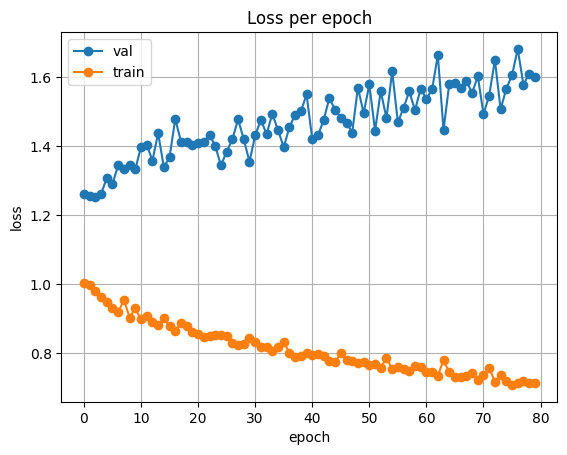

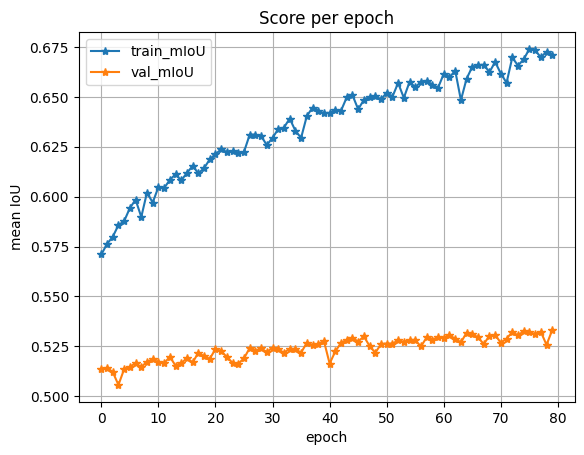

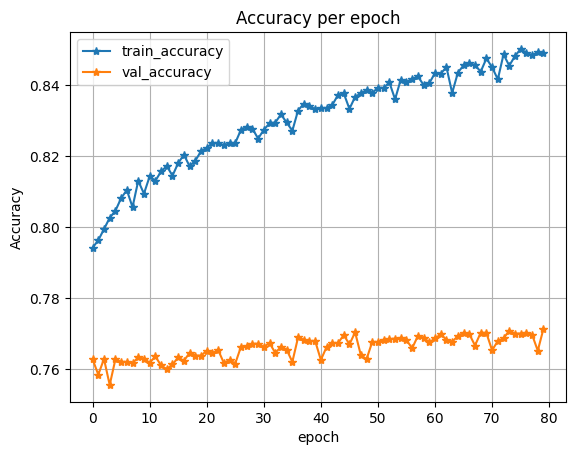

In [28]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [31]:
print(history['val_loss'])
print(history['train_loss'])

print(history['train_miou'])
print(history['val_miou'])

print(history['train_acc'])
print(history['val_acc'])

[1.3913296282291412, 1.2738519723415376, 1.2281584694385528, 1.2062798907756807, 1.1951597254276276, 1.1471688919067382, 1.18185156416893, 1.1675812791585922, 1.1275598285198212, 1.1159436687231064, 1.1148859515190124, 1.126876343011856, 1.0984159586429596, 1.0939852735996247, 1.0592401946783065, 1.0903604220151901, 1.1300457866191864, 1.0468661357164384, 1.034325317621231, 1.021334114074707, 1.0482170742750168, 0.9760480042695999, 0.9696123300790787, 1.0458287168741227, 0.974719772696495, 0.9410536991357803, 0.975914190530777, 1.014246873497963, 0.9938271666765213, 0.9296219168901444, 0.9297586697340011, 0.9369869018793107]
[1.6640827326774597, 1.4483865009943644, 1.3773261286815008, 1.3403262052138647, 1.3045094449122747, 1.2910237539609273, 1.264386014064153, 1.254292142311732, 1.2347884378035863, 1.2178039268652598, 1.1989956653912863, 1.1862808996836345, 1.177735134601593, 1.1525237673521043, 1.1477029310067495, 1.1318006032307943, 1.116539511124293, 1.1112095771630606, 1.10417244